In [ ]:
import sys
import os
from pathlib import Path
curr_dir = os.path.abspath('')
project_dir = Path(curr_dir).parent
sys.path.append(f"{project_dir}")
sys.path.append(f"{project_dir}/src")
sys.path

In [ ]:
from PIL import Image
import numpy as np
from JetRecognizer.ImageGenerator import ImageGenerator, ImageDatasetLoader, load_random_cropped_image_tensors_w_labels_in_dir_generator, load_image_tensors_with_labels_in_dir_generator
from ImagePreprocessing.ImagePreprocessing import load_label_encoder
from Common.DL_FilePaths import SIZE_1920_DIR

In [ ]:
train_dir = SIZE_1920_DIR + '/train'

In [ ]:
def get_image(np_tensor):
    return Image.fromarray(np.uint8(np_tensor*255))

In [ ]:
LABEL_ENCODER_FILENAME = "jet_label_classes.npy"
label_encoder = load_label_encoder(LABEL_ENCODER_FILENAME)

In [ ]:
img_iter = ImageGenerator(train_dir, batch_size=4, label_encoder=label_encoder, one_hot_labels=True)

In [ ]:
# timgs, tlbls = img_iter.__getitem__(0)
timgs, tlbls = next(iter(img_iter))

In [ ]:
get_image(timgs[0])

In [ ]:
# img_dsl = ImageDatasetLoader(train_dir, batch_size=4, label_encoder=label_encoder, one_hot_labels=True)

In [ ]:
# img_ds = ImageDatasetLoader.create_dataset(train_dir, 4)

In [ ]:
import tensorflow as tf
from pathlib import Path
import os

In [ ]:
train_dir_path = Path(train_dir)
ids = tf.data.Dataset.list_files(str(train_dir_path/'*/*'))

In [ ]:
for f in ids.take(5):
    # print(f.numpy())
    pth = Path(f.numpy().decode('UTF-8'))
    basepth = os.path.basename(pth.parent)
    label = basepth[:-1]
    print(label)

In [ ]:
# img_b, label_b = next(iter(ids))

In [ ]:
def process_path(fpath):
    pth = Path(f.numpy().decode('UTF-8'))
    basepth = os.path.basename(pth.parent)
    label = basepth[:-1]
    return fpath, label

In [ ]:
lids = ids.map(
    lambda path: process_path(path)
)

In [ ]:
# for fp, lb in lids.take(5):
    # print(f'path: {fp}, label: {lb}')

In [ ]:
for f in lids.take(5):
    print(f)

In [ ]:
# ipwl = get_img_paths_with_labels(train_dir)
# tds = tf.data.Dataset.list_files(ipwl)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
ipwl = get_img_paths_with_labels(train_dir)

In [ ]:
ipwl[0]

In [ ]:
ipwl = [(ip, lb) for (ip, lb) in ipwl if ip.endswith('.jpg')]

image_paths = [imgp for imgp,_ in ipwl]
image_labels = [imgl for _,imgl in ipwl]

In [ ]:
train_gen = ImageDataGenerator.flow([ImageDatasetLoader.load_image(img_path) for img_path in image_paths if img_path.endswith('.jpg')], y=image_labels)

In [ ]:
# image_paths

In [ ]:
img_pths_t = tf.constant(image_paths)
img_labels_t = tf.constant(image_labels)

In [ ]:
img_pths_t

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_pths_t, img_labels_t))
# dataset = tf.data.Dataset.from_tensors((img_pths_t, img_labels_t))
# dataset = tf.data.Dataset.list_files(image_paths)

In [ ]:
CROP_SIZE = (862, 862, 3)

# step 3: parse every image in the dataset using `map`
def _parse_function(filename, label):
    print(f'label: {label}')
    img_tensor = tf.io.read_file(filename)
    print(f'fn: {filename}, t: {img_tensor}')
    img_tensor = tf.io.decode_jpeg(img_tensor, channels=3)
    img_tensor = tf.image.convert_image_dtype(img_tensor, dtype=tf.float32)
    return img_tensor, label

dataset = dataset.map(lambda fname, label: _parse_function(fname, label))
dataset = dataset.batch(2)

In [ ]:
# step 4: create iterator and final input tensor
# iterator = iter(dataset)
# images, labels = iterator.get_next()

In [ ]:
def crop_norm(img_tensor, label):
    print(f'tensor shape: {img_tensor.shape}')
    _, x, y, _ = img_tensor.shape
    if x is None or y is None:
        return None, None
    else:
        crop_width, crop_height, _ = CROP_SIZE
        if x < crop_width or y < crop_height:
            cropped = tf.image.resize_with_crop_or_pad(img_tensor, crop_width, crop_height)
        else:
            cropped = tf.image.random_crop(img_tensor, size=crop_size)

        return cropped, label

# dataset = dataset.map(crop_norm)

In [ ]:
load_img_tensor_generator, total_len = load_image_tensors_with_labels_in_dir_generator(train_dir, '.jpg')

def random_cropped_gen():
    for img_tensor, label in load_img_tensor_generator:
        x, y, _ = img_tensor.shape
        crop_width, crop_height, _ = CROP_SIZE
        if x < crop_width or y < crop_height:
            cropped = tf.image.resize_with_crop_or_pad(img_tensor, crop_width, crop_height)
        else:
            cropped = tf.image.random_crop(img_tensor, size=CROP_SIZE)

        yield cropped, label

In [ ]:
datagen = tf.data.Dataset.from_generator(random_cropped_gen,
                                         output_signature=(
                                             tf.TensorSpec(shape=CROP_SIZE, dtype=tf.float32),
                                             tf.TensorSpec(shape=(), dtype=tf.string)))

In [ ]:
next(iter(datagen))

In [ ]:
# step 1
img_pths_t = tf.constant(image_paths)
img_labels_t = tf.constant(image_labels)

# step 2: create a dataset returning slices of `filenames`
dataset = tf.data.Dataset.from_tensor_slices((img_pths_t, img_labels_t))

def im_file_to_tensor(file, label):
    def _im_file_to_tensor(file, label):
        path = f"{file.numpy().decode()}"
        im = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
        im = tf.cast(im, tf.float32) / 255.0
        return im, label
    return tf.py_function(_im_file_to_tensor, 
                          inp=(file, label), 
                          Tout=(tf.float32, tf.string))

dataset = dataset.map(im_file_to_tensor)

In [ ]:
# next(iter(dataset))

In [ ]:
def crop_norm_fn(crop_size):
    def _crop_norm(img_tensor, label):
        def crop_norm(img_tensor, label):
            print(f'tensor shape: {img_tensor.shape}')
            x, y, _ = img_tensor.shape
            if x is None or y is None:
                return None, None
            else:
                crop_width, crop_height, _ = crop_size
                if x < crop_width or y < crop_height:
                    cropped = tf.image.resize_with_crop_or_pad(img_tensor, crop_width, crop_height)
                else:
                    cropped = tf.image.random_crop(img_tensor, size=crop_size)

                return cropped, label

        return tf.py_function(crop_norm, 
                              inp=(img_tensor, label), 
                              Tout=(tf.float32, tf.string))
    return _crop_norm

In [ ]:
ds = dataset.map(crop_norm_fn(CROP_SIZE))

In [ ]:
i = iter(ds)

In [ ]:
tensor_img, tensor_label = next(i)

In [ ]:
get_image(tensor_img)

In [1]:
import sys
import os
from pathlib import Path
curr_dir = os.path.abspath('')
project_dir = Path(curr_dir).parent
sys.path.append(f"{project_dir}")
sys.path.append(f"{project_dir}/src")
sys.path

['/Users/albertinopadin/Desktop/Dev/Python Projects/PlaneRecognizer/notebooks',
 '/Users/albertinopadin/miniforge3/envs/dev/lib/python39.zip',
 '/Users/albertinopadin/miniforge3/envs/dev/lib/python3.9',
 '/Users/albertinopadin/miniforge3/envs/dev/lib/python3.9/lib-dynload',
 '',
 '/Users/albertinopadin/miniforge3/envs/dev/lib/python3.9/site-packages',
 '/Users/albertinopadin/miniforge3/envs/dev/lib/python3.9/site-packages/IPython/extensions',
 '/Users/albertinopadin/.ipython',
 '/Users/albertinopadin/Desktop/Dev/Python Projects/PlaneRecognizer',
 '/Users/albertinopadin/Desktop/Dev/Python Projects/PlaneRecognizer/src']

In [2]:
import tensorflow as tf
from PIL import Image
import numpy as np
from JetRecognizer.ImageGenerator import ImageGenerator, ImageDatasetLoader, load_random_cropped_image_tensors_w_labels_in_dir_generator, load_image_tensors_with_labels_in_dir_generator
from ImagePreprocessing.ImagePreprocessing import load_label_encoder
from Common.DL_FilePaths import SIZE_1920_DIR

/Users/albertinopadin/miniforge3/envs/dev/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
train_dir = SIZE_1920_DIR + '/train'

In [4]:
def get_image(np_tensor):
    return Image.fromarray(np.uint8(np_tensor*255))

In [5]:
LABEL_ENCODER_FILENAME = "jet_label_classes.npy"
label_encoder = load_label_encoder(LABEL_ENCODER_FILENAME)

In [6]:
from JetRecognizer.ImageGenerator import ImageDatasetLoader

In [7]:
img_dsl = ImageDatasetLoader(train_dir, batch_size=4, label_encoder=label_encoder, one_hot_labels=True)

Metal device set to: Apple M1 Max


In [8]:
it = iter(img_dsl.dataset)

2022-01-15 15:56:28.260255: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [12]:
img_batch, label_batch = next(it)

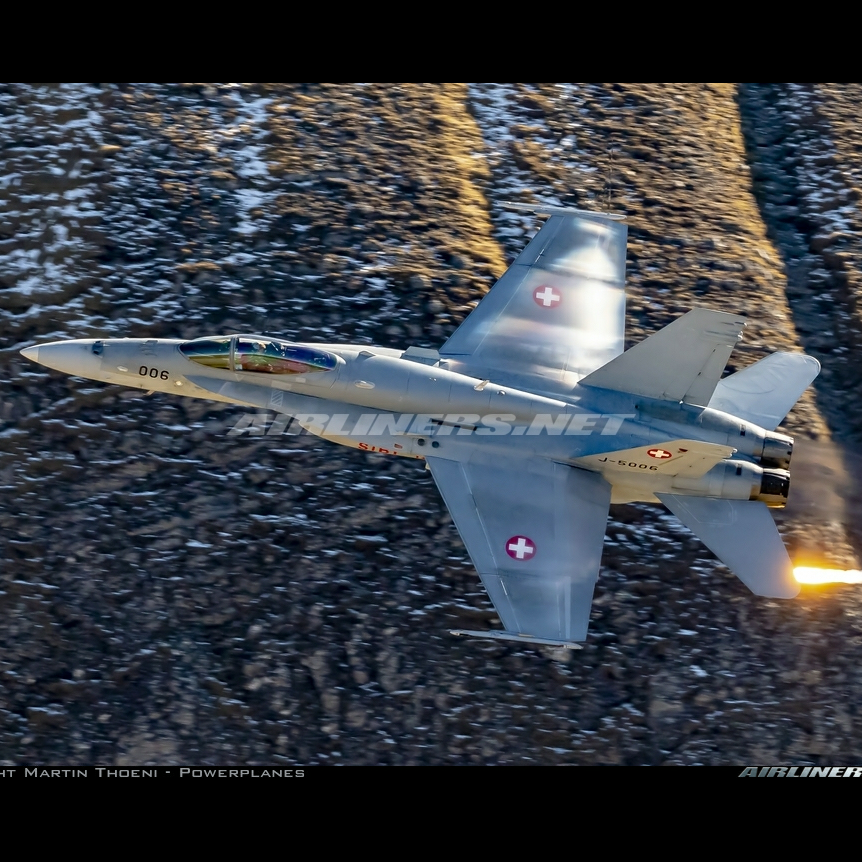

In [13]:
get_image(img_batch[1])

In [14]:
label_batch[1]

<tf.Tensor: shape=(6,), dtype=int8, numpy=array([0, 0, 0, 1, 0, 0], dtype=int8)>

In [ ]:
# label_batch[1].numpy().decode()

In [ ]:
# tf.constant(label_batch[1].numpy().decode())